In [1]:
from transformers import AutoImageProcessor, DPTForDepthEstimation
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.metrics import structural_similarity

Read image and target from train dataset using opencv

In [2]:
img = cv2.imread('../data/nyu2_train/basement_0001a_out/1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread('../data/nyu2_train/basement_0001a_out/1.png')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

Load dinov2 model pre-trained on nyu dataset from Hugging Face and process inputs

In [3]:
image_processor = AutoImageProcessor.from_pretrained("facebook/dpt-dinov2-base-nyu")
model = DPTForDepthEstimation.from_pretrained("facebook/dpt-dinov2-base-nyu")

# prepare image for the model
inputs = image_processor(images=img, return_tensors="pt")

/Users/crountos/Desktop/interviews/depth_estimation/venv/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Get predictions

In [4]:
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

    # interpolate to original size
    preds = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    )

Structural similarity between ground truth mask and prediction

In [5]:
def scale(arr):
    min_value, max_value = np.min(arr), np.max(arr)
    return (arr - min_value) / (max_value - min_value)

preds_n = preds.squeeze().numpy()
preds_n = scale(preds_n)
mask_n = scale(mask)
ssim = structural_similarity(preds_n, mask_n, data_range=1.0)
ssim


0.8430371689508704

Plot target-prediction depth maps

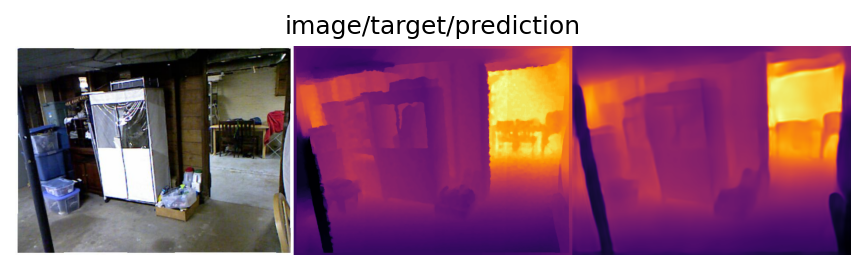

In [6]:
def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3]

@torch.no_grad()
def plot_vals(imgs, targets, preds, n=1,figsize=(17,17),title=''):
    plt.figure(figsize=figsize,dpi=150)
    r = 2 if n == 4 else 8
    c = 2
    for i,idx in enumerate(np.random.randint(0,imgs.size(0),(n,))):
        ax = plt.subplot(r,c,i + 1)
        img,pred,gt = imgs[idx], preds[idx], targets[idx]
        
        pred, gt =  pred.permute(1,2,0).numpy(), gt.permute(1,2,0).numpy()
        pred = colored_depthmap(np.squeeze(pred))
        gt = colored_depthmap(np.squeeze(gt))
        
        image_viz = np.hstack([img, gt, pred])
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")
    title = f'{title}\nimage/target/prediction' if len(title)!=0 else 'image/target/prediction'
    plt.title(title)
    plt.show()
    

plot_vals(
        torch.from_numpy(img).unsqueeze(0),
        torch.from_numpy(mask).unsqueeze(0).unsqueeze(0),
        preds.cpu())